# Modeling FQHC Total Health Center Funding Predictions

The goal of this notebook it to explore various regression models and their accuracy to predict the total health center funding a new entity could receive. 

During preprocessing, I saved 4 train/test splits based on:
1. whether RobustScaler() or PowerTransformer() was applied
2. whether missing data was imputed or removed

I will train and test Linear Regression models and Random Forest Regression models on the 4 data splits. I will also use PCA to reduce the number of components and add relevant components to the existing data (if this increases predictive capabilities)

All results will be scored with R2, Mean Squared Error, and Mean Absolute Error. I'll save cross-validation scoring results for the Linear Models. 

I plan to use GridSearch for the Random Forest Regressors to identify the best parameters. 

Cross-validation for all models will involve 5-fold splits. 

# Import Packages

In [139]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH, MODEL_DATA_PATH

In [141]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [142]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [143]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores['is_pca'] = model_scores['is_pca'].astype(bool)
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [144]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': bool(is_pca),
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [145]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_power.csv')
X_test_rp = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_power.csv')
X_test_ip = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_power.csv')

y_train = pd.read_csv(MODEL_DATA_PATH + 'y_train_data.csv').values.ravel()
y_test = pd.read_csv(MODEL_DATA_PATH + 'y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_test_rounded.csv').values.ravel()

In [146]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(939, 34) (939,) (939,)
(403, 34) (403,) (403,)


# Linear Models

## 1. Reduced & Robust Scaled Data


### 1.a. Linear Regression

In [147]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6192887238434832, 0.05038088971594099),
 'neg_mean_squared_error': (-2871632448620.801, 177617879452.71265),
 'neg_mean_absolute_error': (-1144394.4152232367, 34997.04205098674)}

#### Model Training and Evaluation

R2 Score: -0.20755367955348114, Root Mean Squared Error: 2938021.915211188, Mean Absolute Error: 1253841.794605104


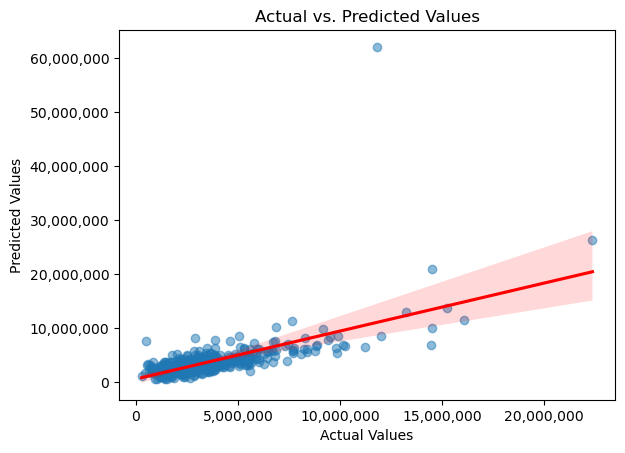

In [148]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_robust', bool(False), 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [149]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.588595e+06,2.938022e+06,1.089008e+06,1.253842e+06,0.670849,-0.207554,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None


### 1.b. Linear Regression with PCA

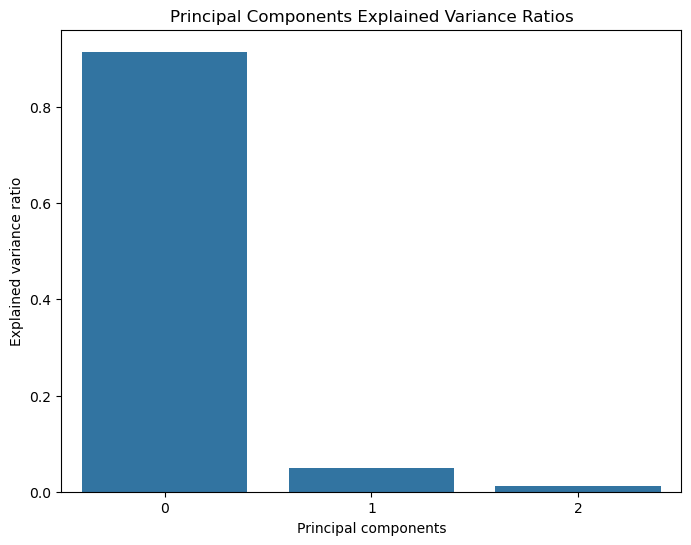

                                 PC 1      PC 2      PC 3
public_insurance_ratio       0.999915 -0.002457  0.000435
lep_patients_ratio           0.005495  0.010289  0.051059
diverse_race_proportion      0.004229 -0.000447 -0.023623
uninsured_ratio              0.003486 -0.006484 -0.021574
total_0_17_ratio             0.003116  0.002953  0.089383
fpl_100_below_ratio          0.002612  0.003242  0.016856
poverty_ratio                0.002612  0.003242  0.016856
total_other_revenue          0.002496  0.984321 -0.149994
total_grant_funding          0.001951  0.092255  0.374108
grants_to_rev_ratio          0.001475 -0.063930  0.031000
low_income_ratio             0.001465  0.000873  0.012967
other_revenue_category_Zero  0.001397 -0.008616 -0.014785
hispanic_proportion          0.001269  0.007896  0.061952
total_patients               0.001146  0.077763  0.399767
state_freq_enc               0.000616  0.002306  0.151730


In [150]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [151]:
X_train_pca_df = pd.DataFrame(X_train_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_test_rr.index)

X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: -0.2042935636057983, Root Mean Squared Error: 2934053.2445847276, Mean Absolute Error: 1253702.0372208436


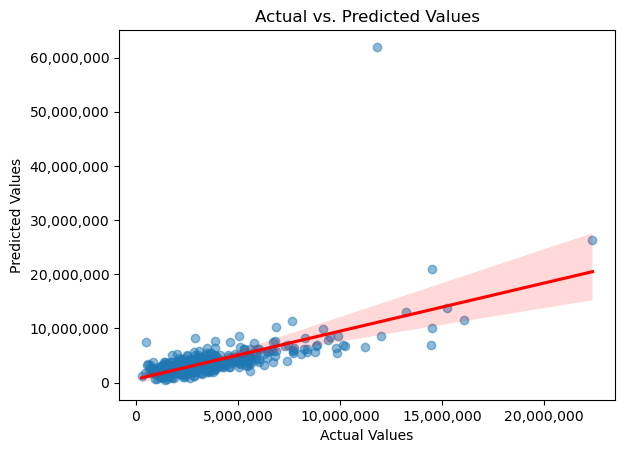

In [152]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [153]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.588595e+06,2.938022e+06,1.089008e+06,1.253842e+06,0.670849,-0.207554,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None
1,Linear Regression,reduced_robust,True,1.588587e+06,2.934053e+06,1.089086e+06,1.253702e+06,0.670852,-0.204294,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None


### 1.c. Rounded

R2 Score: -0.20446267406742002, Root Mean Squared Error: 2933947.59503969, Mean Absolute Error: 1253893.235571587


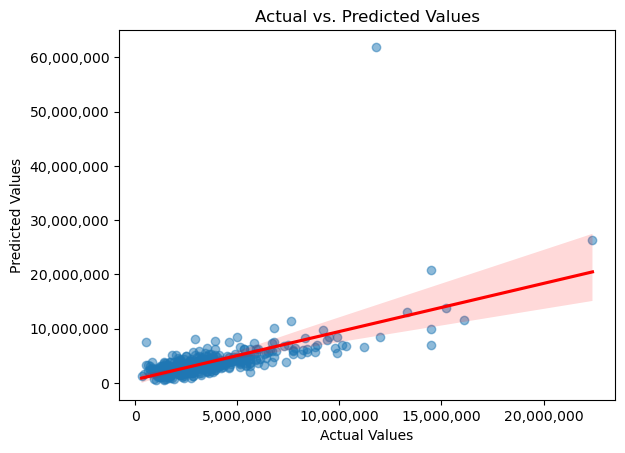

In [154]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## 2. Reduced & Power Transformed Data

### 2.a. Linear Regression

In [155]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.569593783357331, 0.024638954318349324),
 'neg_mean_squared_error': (-3276519526356.2715, 241349115077.8303),
 'neg_mean_absolute_error': (-1275754.144530016, 51012.66571377516)}

R2 Score: 0.6125427593438423, Root Mean Squared Error: 1664231.3499044818, Mean Absolute Error: 1225130.6077727182


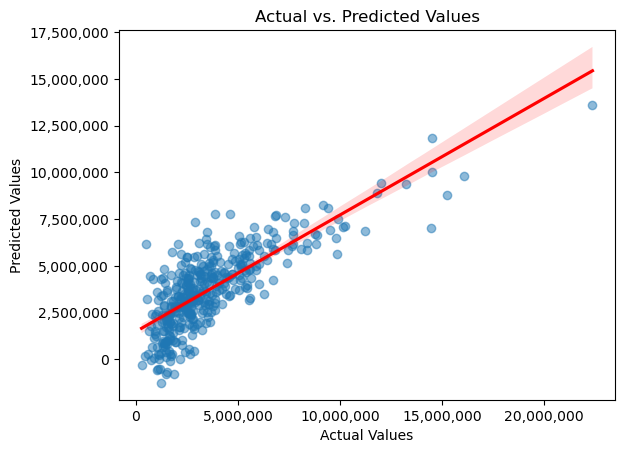

In [156]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 2.b. Linear Regression with PCA

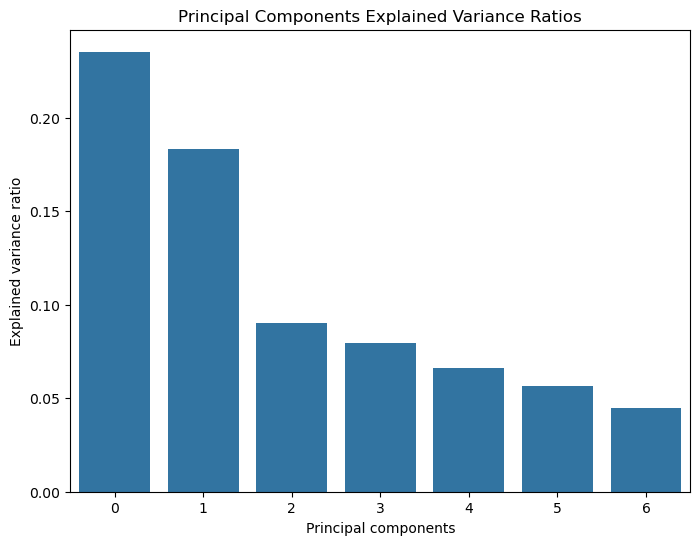

                                           PC 1      PC 2      PC 3      PC 4  \
private_insurance_ratio                0.237472  0.279184  0.021147  0.009464   
medicare_18_up_ratio                   0.234160  0.214280  0.259878 -0.064046   
total_18_up_ratio                      0.204062 -0.109973  0.430370  0.270914   
grants_to_rev_ratio                    0.052584 -0.093603 -0.019820 -0.219937   
other_revenue_category_Less than 100K  0.044338 -0.024536 -0.016427 -0.016675   
other_revenue_category_Zero            0.031397 -0.049634  0.003553 -0.062037   
other_revenue_category_Over 30M       -0.000713  0.000152  0.000507  0.002171   
FundingCHC                            -0.001339  0.041125 -0.043579 -0.011725   
other_revenue_category_500K to 1M     -0.014652  0.018026 -0.005509  0.029112   
FundingPH                             -0.015078 -0.000637  0.005526 -0.001639   
fin_confidential                      -0.015878  0.019502  0.006065 -0.000417   
ops_confidential            

In [157]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [158]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)

X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6123972843162608, Root Mean Squared Error: 1664543.7474483128, Mean Absolute Error: 1225266.7965260546


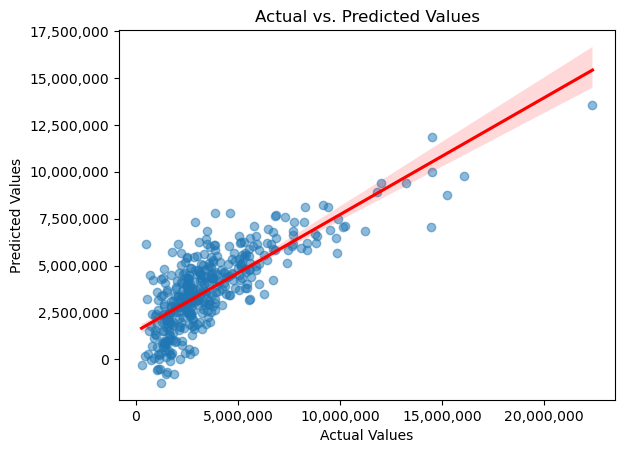

In [159]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 2.c. Rounded

In [160]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.5693271248013724, 0.024507173224308534),
 'neg_mean_squared_error': (-3279261470032.423, 240868023036.00507),
 'neg_mean_absolute_error': (-1276324.4309612878, 51343.42474737039)}

R2 Score: 0.6127798384009373, Root Mean Squared Error: 1663545.4100837188, Mean Absolute Error: 1223270.2411893618


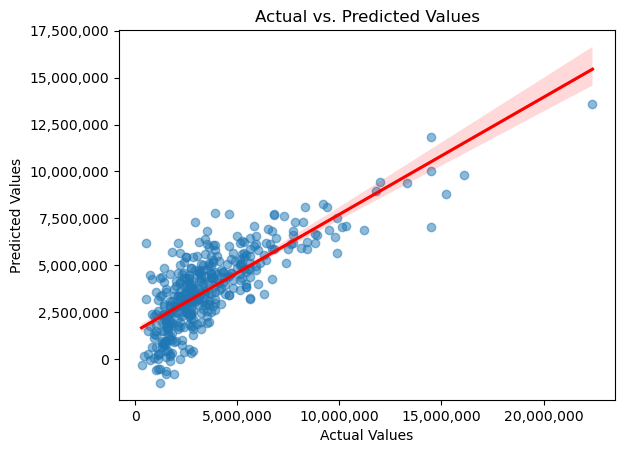

In [161]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## 3. Imputed & Robust Scaled Data

### 3.a. Linear Regression

In [162]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6202262311478232, 0.05014037319985167),
 'neg_mean_squared_error': (-2864640273475.3203, 176976151575.53955),
 'neg_mean_absolute_error': (-1143673.4920655354, 31161.39684080512)}

R2 Score: -0.10461493119670506, Root Mean Squared Error: 2810006.1008266406, Mean Absolute Error: 1244483.0226955204


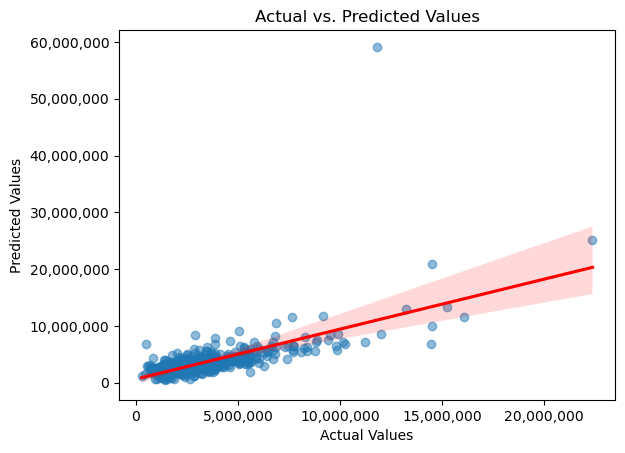

In [163]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 3.b. Linear Regression PCA

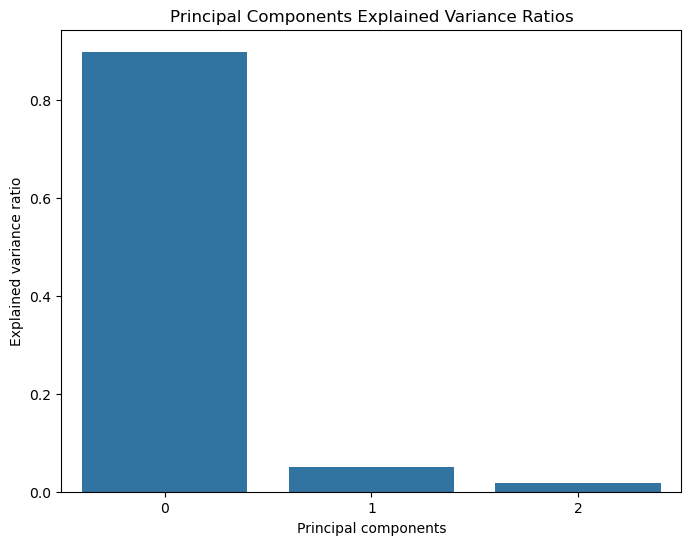

                                 PC 1      PC 2      PC 3
public_insurance_ratio       0.999903 -0.003449  0.002885
lep_patients_ratio           0.005501  0.014788 -0.059390
diverse_race_proportion      0.004227 -0.001943  0.020290
uninsured_ratio              0.003489 -0.005124 -0.007710
total_0_17_ratio             0.003120  0.006878 -0.063726
total_sfs                    0.002946  0.106928 -0.309423
fpl_100_below_ratio          0.002614  0.004298 -0.017013
poverty_ratio                0.002614  0.004298 -0.017013
total_other_revenue          0.002533  0.950622  0.295094
total_enabling_visits        0.002503  0.078936 -0.260966
enabling_patients            0.002354  0.064040 -0.239870
total_grant_funding          0.001974  0.110700 -0.288430
grants_to_rev_ratio          0.001474 -0.060450 -0.038155
low_income_ratio             0.001466  0.001877 -0.014953
other_revenue_category_Zero  0.001396 -0.009258  0.010581


In [164]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [165]:
X_train_pca_df = pd.DataFrame(X_train_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_train_ir.index)

X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: -0.10462395068319275, Root Mean Squared Error: 2810017.5730418013, Mean Absolute Error: 1244495.3126550869


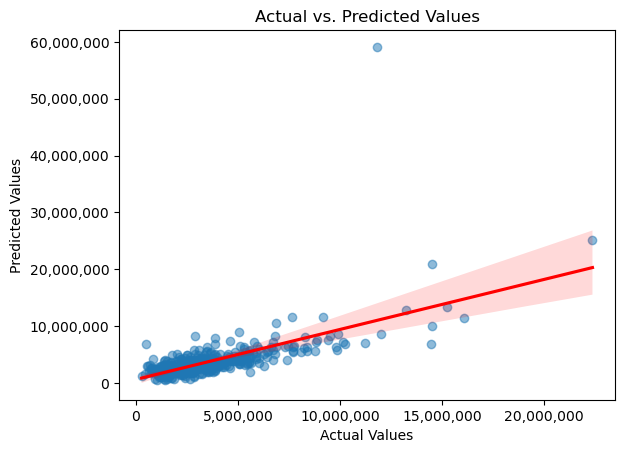

In [166]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 3.c. Rounded

R2 Score: -0.1027914361178699, Root Mean Squared Error: 2807387.5647204043, Mean Absolute Error: 1245405.3038053906


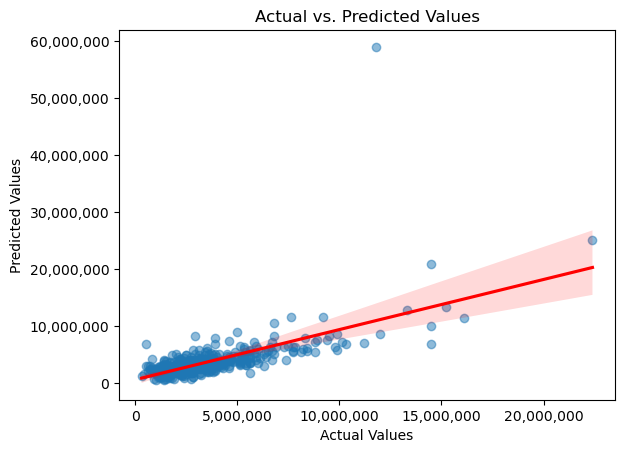

In [167]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## 4. Imputed & Power Transformed Data

### 4.a. Linear Regression

In [168]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5742610438499647, 0.02281675502106882),
 'neg_mean_squared_error': (-3243658308507.9043, 263274367683.5537),
 'neg_mean_absolute_error': (-1274707.8891726937, 53346.895717794454)}

R2 Score: 0.622305164004278, Root Mean Squared Error: 1643131.5385256715, Mean Absolute Error: 1215499.7782735652


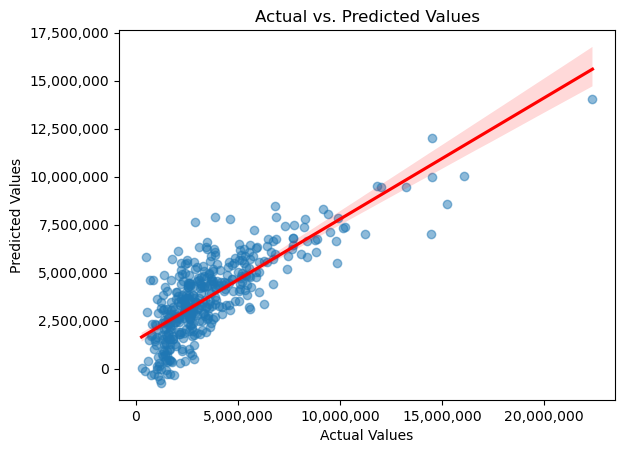

In [169]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 4.b. Linear Regression PCA

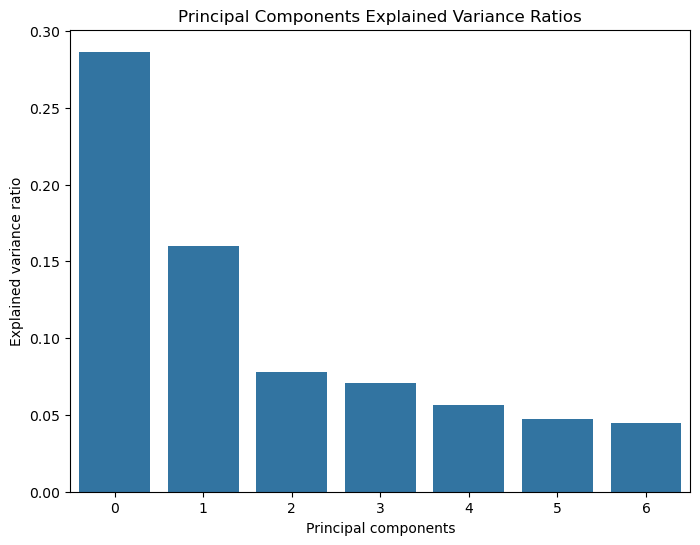

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_visits                 0.317379  0.126240 -0.024677 -0.043873  0.034344   
total_cost_care              0.312751  0.125191 -0.036272 -0.025655  0.113004   
total_patients               0.308002  0.131090  0.013250 -0.052694 -0.010708   
total_grant_funding          0.289128  0.037995 -0.045194  0.052390  0.055917   
TotalWeeklyHoursOfOperation  0.270285  0.156989 -0.095686 -0.159287 -0.148857   
total_sfs                    0.259573 -0.054563 -0.079284  0.223497 -0.096115   
total_sites                  0.255985  0.148632 -0.111014 -0.180692 -0.163494   
ZipCode_Count                0.251751  0.077955 -0.053677 -0.083521  0.050550   
enabling_patients            0.227671 -0.019319 -0.192966  0.104051 -0.058284   
total_enabling_visits        0.221234 -0.013423 -0.201788  0.095085 -0.041309   
hispanic_proportion          0.175384 -0.220196  0.072906  0.358649  0.007266   
lep_patients_ratio          

In [170]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [171]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6224289860015972, Root Mean Squared Error: 1642862.1775398417, Mean Absolute Error: 1215412.9106699752


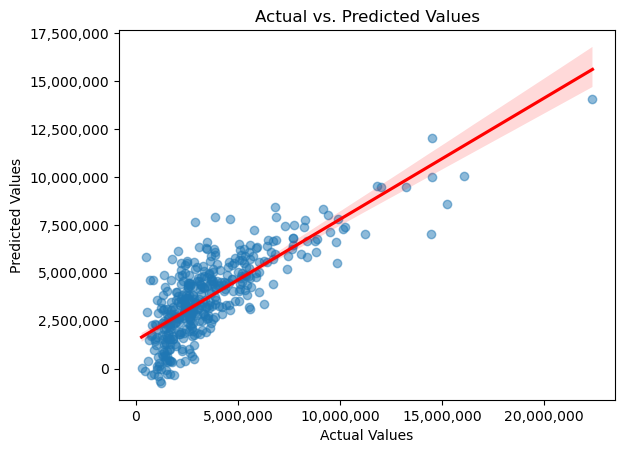

In [172]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

In [173]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 4.c. Rounded

R2 Score: 0.6225404739968687, Root Mean Squared Error: 1642445.1480268924, Mean Absolute Error: 1213404.1496407853


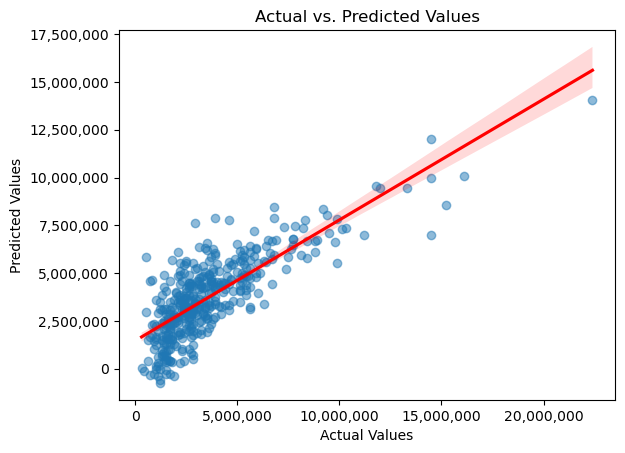

In [174]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [175]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
6,Linear Regression,imputed_robust,False,1.576343e+06,2.810006e+06,1.082088e+06,1.244483e+06,0.675906,-0.104615,0.620226,0.050140,-2.864640e+12,1.769762e+11,-1.143673e+06,31161.396841,None
7,Linear Regression,imputed_robust,True,1.576351e+06,2.810018e+06,1.082081e+06,1.244495e+06,0.675903,-0.104624,0.620226,0.050140,-2.864640e+12,1.769762e+11,-1.143673e+06,31161.396841,None
8,Linear Regression,imputed_robust_rounded,False,1.576346e+06,2.807388e+06,1.081835e+06,1.245405e+06,0.675947,-0.102791,0.620178,0.050113,-2.865861e+12,1.806949e+11,-1.143957e+06,32662.022465,None
0,Linear Regression,reduced_robust,False,1.588595e+06,2.938022e+06,1.089008e+06,1.253842e+06,0.670849,-0.207554,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None
1,Linear Regression,reduced_robust,True,1.588587e+06,2.934053e+06,1.089086e+06,1.253702e+06,0.670852,-0.204294,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None
2,Linear Regression,reduced_robust_rounded,False,1.588439e+06,2.933948e+06,1.089174e+06,1.253893e+06,0.670956,-0.204463,0.619287,0.050349,-2.872429e+12,1.799867e+11,-1.144797e+06,34743.122449,None
9,Linear Regression,imputed_power,False,1.687221e+06,1.643132e+06,1.194777e+06,1.215500e+06,0.628710,0.622305,0.574261,0.022817,-3.243658e+12,2.632744e+11,-1.274708e+06,53346.895718,None
10,Linear Regression,imputed_power,True,1.687190e+06,1.642862e+06,1.194952e+06,1.215413e+06,0.628724,0.622429,0.574261,0.022817,-3.243658e+12,2.632744e+11,-1.274708e+06,53346.895718,None
11,Linear Regression,imputed_power_rounded,False,1.687938e+06,1.642445e+06,1.195219e+06,1.213404e+06,0.628443,0.622540,0.573939,0.022664,-3.246766e+12,2.622630e+11,-1.275267e+06,53134.722175,None
3,Linear Regression,reduced_power,False,1.705168e+06,1.664231e+06,1.206401e+06,1.225131e+06,0.620769,0.612543,0.569594,0.024639,-3.276520e+12,2.413491e+11,-1.275754e+06,51012.665714,None


# Ensemble Models

## 5. Reduced & Robust Scaled Data

### 5.a. Random Forest Regression

In [176]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6425812515889622
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.6424920251054531, Root Mean Squared Error: 1598617.9133013187, Mean Absolute Error: 1119044.8482878413


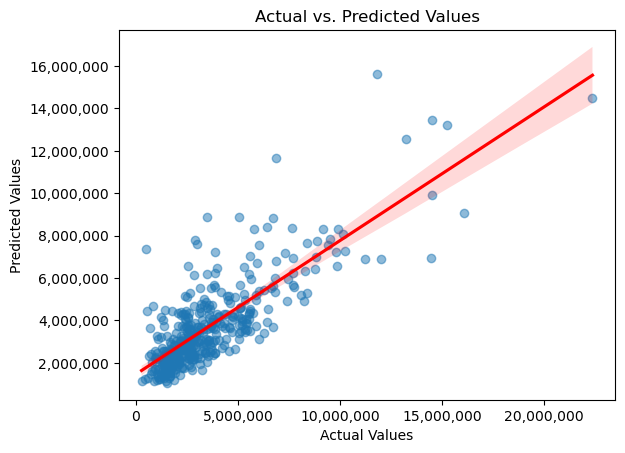

                             feature_importance
total_patients                         0.362753
TotalWeeklyHoursOfOperation            0.165933
total_grant_funding                    0.088971
total_sites                            0.037325
uninsured_ratio                        0.034824
ZipCode_Count                          0.027564
diverse_race_proportion                0.025729
total_other_revenue                    0.021845
SiteCity_Count                         0.020502
medicaid_ratio                         0.017425
hispanic_proportion                    0.017191
grants_to_rev_ratio                    0.016605
low_income_ratio                       0.014396
poverty_ratio                          0.013938
FundingMHC                             0.013866


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [177]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 5.b. RandomForestRegressor with PCA

R2 Score: 0.6412864604609974, Root Mean Squared Error: 1601311.0213992943, Mean Absolute Error: 1129701.8472456574


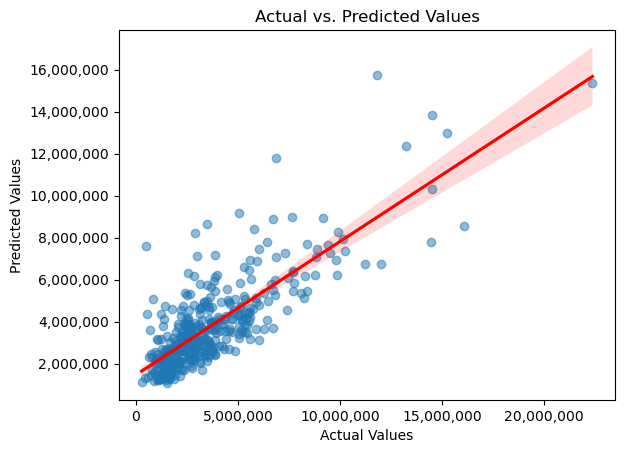

                             feature_importance
total_patients                         0.374016
TotalWeeklyHoursOfOperation            0.145181
total_grant_funding                    0.096876
total_sites                            0.036126
uninsured_ratio                        0.034380
total_other_revenue                    0.025489
ZipCode_Count                          0.025360
diverse_race_proportion                0.024508
SiteCity_Count                         0.020763
medicaid_ratio                         0.019991
hispanic_proportion                    0.016014
FundingMHC                             0.014371
PC 1                                   0.013887
private_insurance_ratio                0.013750
poverty_ratio                          0.013748


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [178]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 5.c. Rounded

R2 Score: 0.6481349887006498, Root Mean Squared Error: 1585782.8666775723, Mean Absolute Error: 1110124.069478908


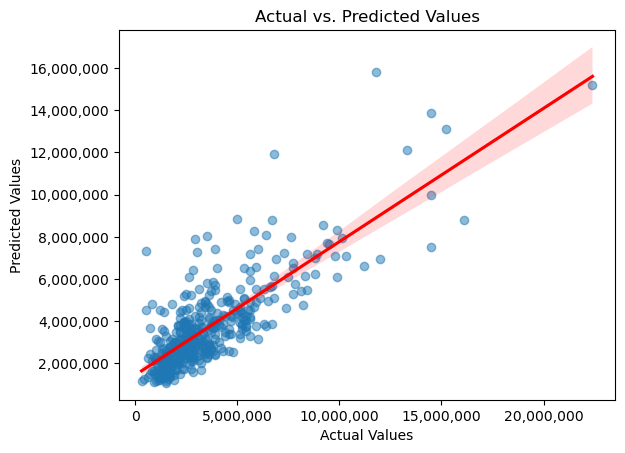

                             feature_importance
total_patients                         0.374229
TotalWeeklyHoursOfOperation            0.141591
total_grant_funding                    0.102021
total_sites                            0.043883
uninsured_ratio                        0.035015
ZipCode_Count                          0.027857
diverse_race_proportion                0.027174
total_other_revenue                    0.020786
SiteCity_Count                         0.017840
hispanic_proportion                    0.016598
medicaid_ratio                         0.016233
grants_to_rev_ratio                    0.015404
FundingMHC                             0.014484
fpl_100_below_ratio                    0.013752
poverty_ratio                          0.013578


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [179]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## 6. Reduced & Power Transformed Data

### 6.a. Random Forest Regressor with GridSearch

In [180]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6441385982494474
Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.646346066740101, Root Mean Squared Error: 1589977.777602703, Mean Absolute Error: 1110669.3197356493


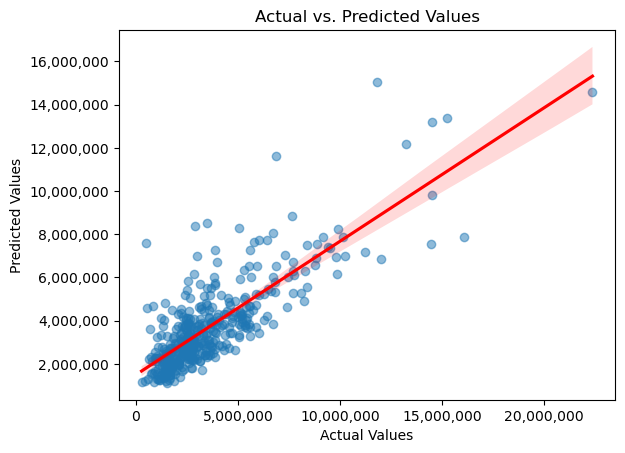

                             feature_importance
total_patients                         0.391041
TotalWeeklyHoursOfOperation            0.131822
total_grant_funding                    0.091285
total_sites                            0.054938
uninsured_ratio                        0.033802
ZipCode_Count                          0.029200
diverse_race_proportion                0.028137
total_other_revenue                    0.024069
SiteCity_Count                         0.018170
medicaid_ratio                         0.016684
hispanic_proportion                    0.015088
FundingMHC                             0.014895
private_insurance_ratio                0.014402
grants_to_rev_ratio                    0.014132
poverty_ratio                          0.013665


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [181]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 6.b. RandomForestRegressor with PCA

R2 Score: 0.6386405658889708, Root Mean Squared Error: 1607205.858703103, Mean Absolute Error: 1120082.4562064973


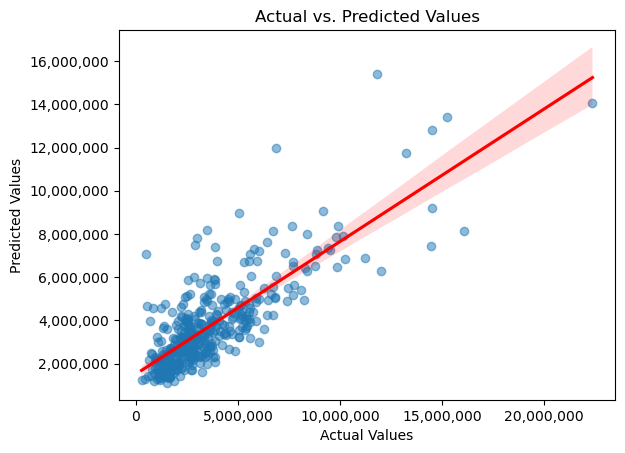

                             feature_importance
total_patients                         0.341477
TotalWeeklyHoursOfOperation            0.127189
total_grant_funding                    0.090734
total_sites                            0.054879
PC 1                                   0.047619
uninsured_ratio                        0.023175
ZipCode_Count                          0.020732
SiteCity_Count                         0.018998
PC 3                                   0.018645
PC 4                                   0.017717
diverse_race_proportion                0.017033
total_other_revenue                    0.015995
hispanic_proportion                    0.015596
PC 6                                   0.014753
PC 5                                   0.013251


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [182]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 6.c. Rounded

R2 Score: 0.6368476989351589, Root Mean Squared Error: 1611016.8380936782, Mean Absolute Error: 1120731.989617695


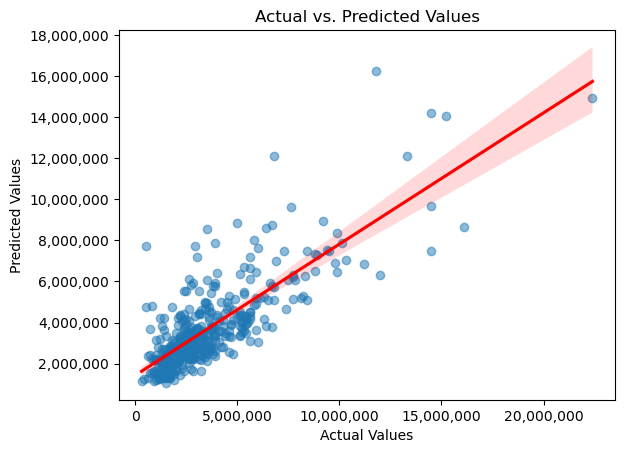

                             feature_importance
total_patients                         0.389686
TotalWeeklyHoursOfOperation            0.167032
total_grant_funding                    0.086748
uninsured_ratio                        0.035317
total_sites                            0.032248
diverse_race_proportion                0.026535
ZipCode_Count                          0.025608
total_other_revenue                    0.023302
SiteCity_Count                         0.018698
medicaid_ratio                         0.017703
hispanic_proportion                    0.015519
FundingMHC                             0.014237
private_insurance_ratio                0.013684
poverty_ratio                          0.012736
grants_to_rev_ratio                    0.011842


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [183]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## 7. Imputed & Robust Scaled Data

### 7.a. Random Forest Regressor

In [184]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6367433500606411
Best parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.6356220030950356, Root Mean Squared Error: 1613904.677074134, Mean Absolute Error: 1117702.0231761788


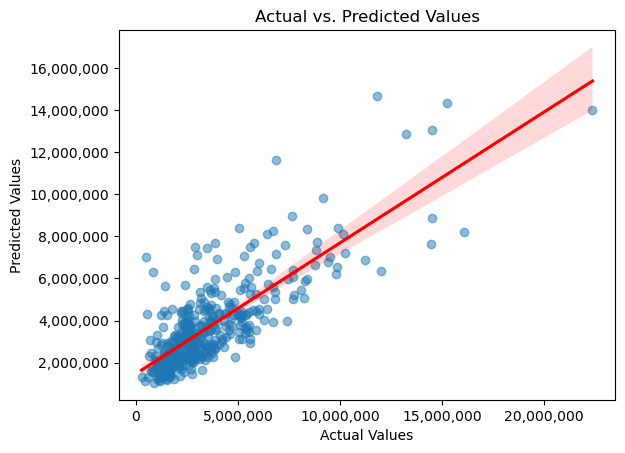

                             feature_importance
total_patients                         0.167275
total_cost_care                        0.131467
total_visits                           0.116962
TotalWeeklyHoursOfOperation            0.094684
total_sfs                              0.048951
total_grant_funding                    0.048548
total_sites                            0.037755
ZipCode_Count                          0.037580
uninsured_ratio                        0.026754
medicaid_ratio                         0.022004
diverse_race_proportion                0.021580
enabling_patients                      0.019142
fpl_100_below_ratio                    0.016522
total_other_revenue                    0.016171
total_enabling_visits                  0.016101


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [185]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 7.c. Rounded

R2 Score: 0.6349348788655766, Root Mean Squared Error: 1615254.0935099022, Mean Absolute Error: 1121900.7444168734


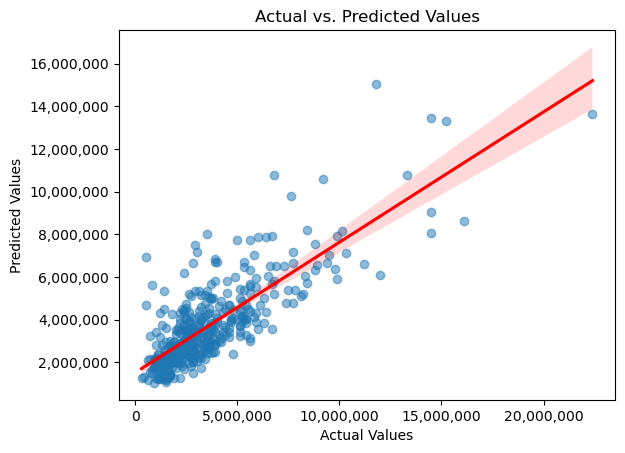

                             feature_importance
total_patients                         0.188282
total_cost_care                        0.114925
total_visits                           0.101301
TotalWeeklyHoursOfOperation            0.090801
total_grant_funding                    0.085684
total_sites                            0.035198
total_sfs                              0.032251
enabling_patients                      0.030679
ZipCode_Count                          0.029882
uninsured_ratio                        0.024788
diverse_race_proportion                0.024163
total_other_revenue                    0.019118
medicaid_ratio                         0.018025
SiteCity_Count                         0.014628
grants_to_rev_ratio                    0.014229


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [186]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## 8. Imputed & Power Transformed Data

### 8.a. Random Forest Regressor

In [187]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6302534602329596
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 10, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.62574758019709, Root Mean Squared Error: 1635626.4186284041, Mean Absolute Error: 1125777.8655769231


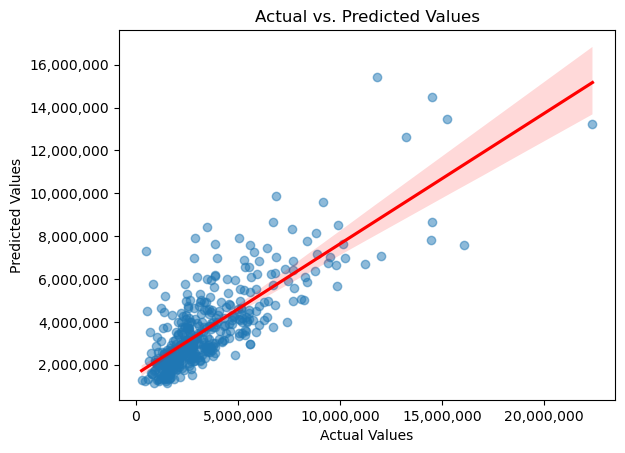

                             feature_importance
total_patients                         0.131890
total_visits                           0.096760
total_cost_care                        0.092074
TotalWeeklyHoursOfOperation            0.066997
total_sfs                              0.046787
total_grant_funding                    0.046526
total_sites                            0.038179
ZipCode_Count                          0.033920
uninsured_ratio                        0.033493
diverse_race_proportion                0.029573
medicaid_ratio                         0.024348
total_other_revenue                    0.022391
enabling_patients                      0.021557
private_insurance_ratio                0.021302
low_income_ratio                       0.021001


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [188]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ip, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 8.b. Rounded

R2 Score: 0.6378328480849793, Root Mean Squared Error: 1608830.1939770118, Mean Absolute Error: 1119878.4119106699


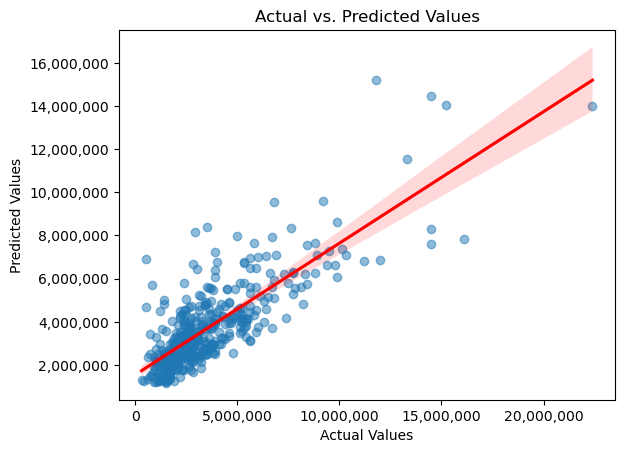

                             feature_importance
total_patients                         0.128227
total_cost_care                        0.092839
total_visits                           0.092559
TotalWeeklyHoursOfOperation            0.070165
total_sfs                              0.049262
total_grant_funding                    0.048211
total_sites                            0.035267
ZipCode_Count                          0.035064
uninsured_ratio                        0.033450
diverse_race_proportion                0.028431
medicaid_ratio                         0.025242
SiteCity_Count                         0.022177
private_insurance_ratio                0.021590
total_0_17_ratio                       0.021352
total_other_revenue                    0.021312


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_17166/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [189]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ip, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [194]:
pd.options.display.float_format = '{:.6f}'.format
model_scores.sort_values('score_mae_test', ascending=True)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
14,Random Forest Regressor,reduced_robust_rounded,False,630797.054201,1585782.866678,412195.420660,1110124.069479,0.948109,0.648135,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,768620.611317,1589977.777603,547509.349094,1110669.319736,0.922946,0.646346,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,655436.408110,1613904.677074,434063.307604,1117702.023176,0.943969,0.635622,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,632939.587867,1598617.913301,413942.391917,1119044.848288,0.947749,0.642492,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
21,Random Forest Regressor,imputed_power_rounded,False,634125.770290,1608830.193977,419532.481363,1119878.411911,0.947560,0.637833,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
16,Random Forest Regressor,reduced_power,True,749307.902139,1607205.858703,539728.376597,1120082.456206,0.926770,0.638641,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,749721.977267,1611016.838094,546154.636207,1120731.989618,0.926698,0.636848,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
19,Random Forest Regressor,imputed_robust_rounded,False,682607.713650,1615254.093510,435640.042599,1121900.744417,0.939235,0.634935,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
20,Random Forest Regressor,imputed_power,False,634055.488325,1635626.418628,414836.895636,1125777.865577,0.947565,0.625748,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,621572.777584,1601311.021399,408994.770059,1129701.847246,0.949609,0.641286,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."


In [195]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_mae_test', ascending=True).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_mae_test', ascending=True).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_robust_rounded,False,630797.054201,1585782.866678,412195.420660,1110124.069479,0.948109,0.648135,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_power,False,768620.611317,1589977.777603,547509.349094,1110669.319736,0.922946,0.646346,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,imputed_power_rounded,False,1687937.540870,1642445.148027,1195219.443647,1213404.149641,0.628443,0.622540,0.573939,0.022664,-3246765522397.410156,262262973449.210358,-1275266.869126,53134.722175,None
3,Linear Regression,imputed_power,True,1687189.667107,1642862.177540,1194951.665602,1215412.910670,0.628724,0.622429,0.574261,0.022817,-3243658308507.904297,263274367683.553711,-1274707.889173,53346.895718,None


In [196]:
# best_params for the first rf model
best_params_first_model = top_models.loc[0, 'best_params']
print(best_params_first_model)

# best_params for the second rf model
best_params_second_model = top_models.loc[1, 'best_params']
print(best_params_second_model)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Model Tuning

### **Reduced Robust Model with Rounded Target**

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [197]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [200, 300, 400], 
    'max_depth': [None, 20],
    'max_features': ['sqrt', 15, 20, 'log2'], 
    'min_samples_split': [2, 3, 5], 
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error'], 
    'bootstrap': [True],  
    'n_jobs': [-1], 
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_rr, y_train_rounded)

y_pred = forest_gs.predict(X_test_rr)
print(forest_gs.score(X_test_rr, y_test_rounded))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6456005654886134
Best parameters: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 20, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 200, 'n_jobs': -1}


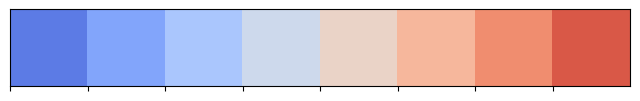

In [228]:
custom_palette = sns.color_palette('coolwarm', 8)
sns.set_palette(custom_palette)

custom_colors_binary = [custom_palette[0], custom_palette[6]]

sns.palplot(custom_palette)
plt.show()

R2 Score: 0.6440644231755636, Root Mean Squared Error: 1594929.0892910904, Mean Absolute Error: 1105515.4392846383


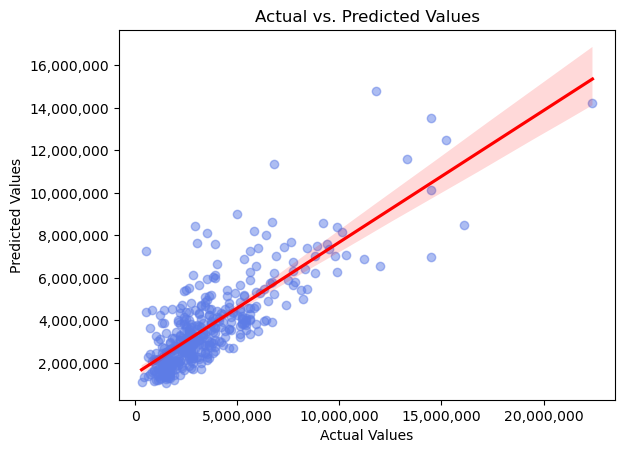

                             feature_importance
total_patients                         0.440454
TotalWeeklyHoursOfOperation            0.143136
total_grant_funding                    0.092270
total_sites                            0.042729
uninsured_ratio                        0.035927
diverse_race_proportion                0.023261
total_other_revenue                    0.019934
ZipCode_Count                          0.019380
SiteCity_Count                         0.017437
FundingMHC                             0.015360
medicaid_ratio                         0.013903
private_insurance_ratio                0.012543
hispanic_proportion                    0.012529
fpl_100_below_ratio                    0.011091
grants_to_rev_ratio                    0.010183
state_freq_enc                         0.009561
FundingHO                              0.009547
medicare_18_up_ratio                   0.009490
poverty_ratio                          0.009211
total_18_up_ratio                      0

In [229]:
rf_model_1 = RandomForestRegressor(**best_params, random_state=33)

rf_model_1.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_1, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model_1.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(20))

In [201]:
y_pred_train = rf_model_1.predict(X_train_rr)

In [257]:
residuals = y_test - y_pred

# Create a DataFrame to analyze the residuals
results_df = pd.DataFrame({
    'Actual': y_test_rounded.flatten(), 
    'Predicted': y_pred.flatten(),
    'Residuals': residuals.flatten(),
    'Absolute_Residuals': abs(residuals).flatten()
})

# Sort the df by absolute residuals in descending order
results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

results_df[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,403.00
mean,1105465.56
std,1149020.66
min,631.14
25%,328886.52
50%,797874.99
75%,1466657.96
max,8153076.15


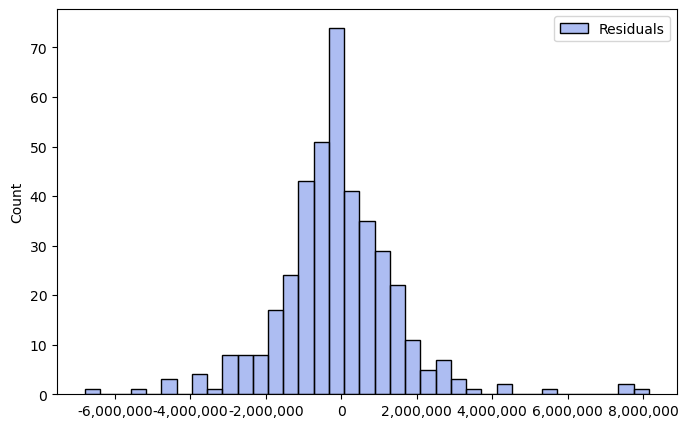

In [258]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(results_df[['Residuals']])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 


In [259]:
results_df

,Actual,Predicted,Residuals,Absolute_Residuals
373,22400000,14229272.849373,8153076.150627,8153076.150627
346,16100000,8467454.549209,7629811.450791,7629811.450791
18,14500000,6999554.905511,7450987.094489,7450987.094489
124,500000,7273475.117938,-6785975.117938,6785975.117938
227,2900000,8437231.941873,-5518588.941873,5518588.941873
...,...,...,...,...
101,4300000,4312603.862804,18461.137196,18461.137196
388,3500000,3518722.799423,-16596.799423,16596.799423
336,3100000,3084085.749667,-9777.749667,9777.749667
308,2500000,2549144.228688,-4134.228688,4134.228688


In [260]:
residuals_train = y_train_rounded - y_pred_train

# Create a DataFrame to analyze the residuals
results_df_train = pd.DataFrame({
    'Actual': y_train_rounded.flatten(), 
    'Predicted': y_pred_train.flatten(),
    'Residuals': residuals_train.flatten(),
    'Absolute_Residuals': abs(residuals_train).flatten()
})

# Sort the df by absolute residuals in descending order
results_df_train = results_df_train.sort_values(by='Absolute_Residuals', ascending=False)

Text(0.5, 1.0, 'Train Prediction Residuals')

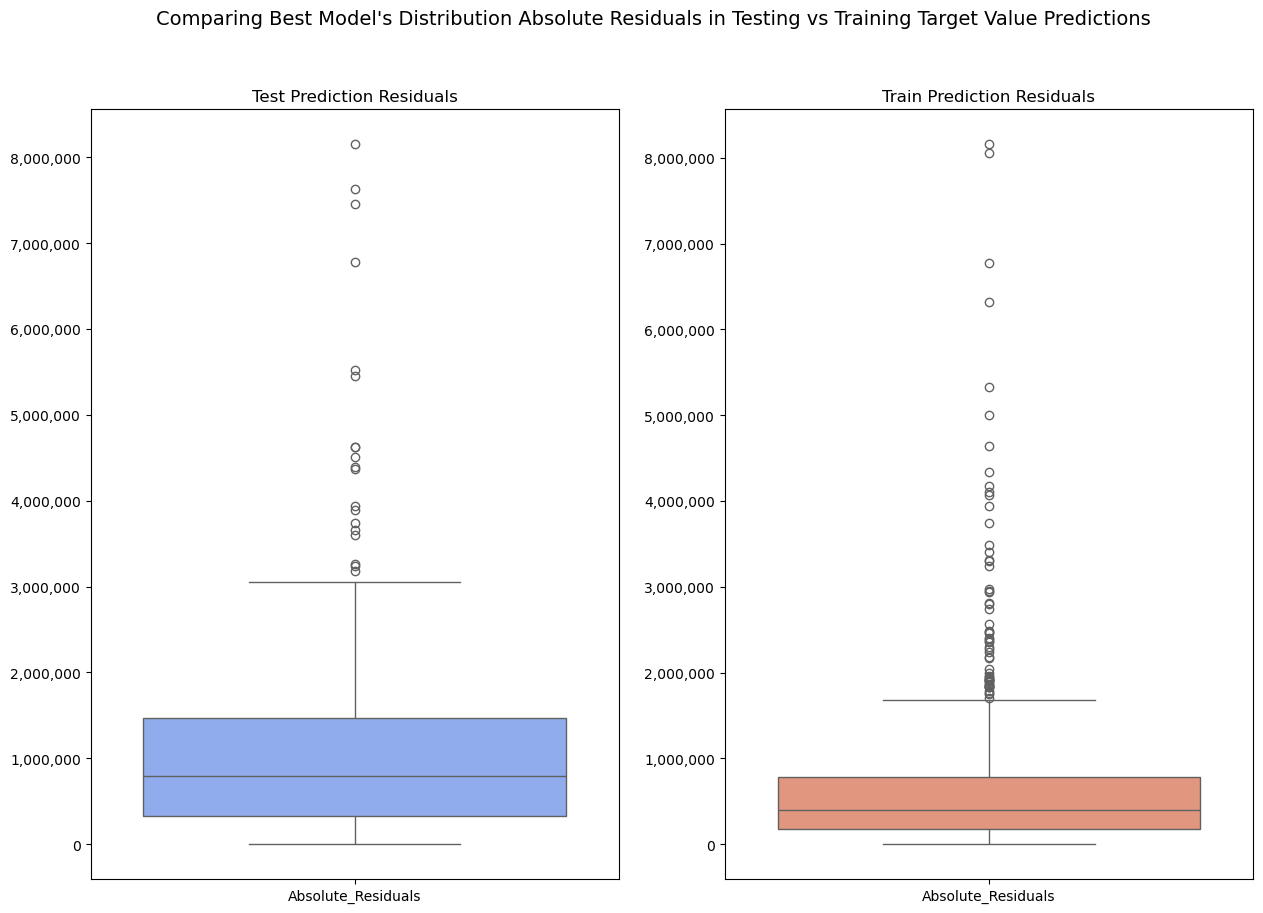

In [261]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

fig.suptitle("Comparing Best Model's Distribution Absolute Residuals in Testing vs Training Target Value Predictions", fontsize=14)

sns.boxplot(results_df[['Absolute_Residuals']], ax=ax[0], color=custom_palette[1])
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax[0].set_title('Test Prediction Residuals')

sns.boxplot(results_df_train[['Absolute_Residuals']], ax=ax[1], color=custom_palette[6])
ax[1].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax[1].set_title('Train Prediction Residuals')


In [262]:
combined_data_test = pd.merge(X_test_rr, results_df, left_index=True, right_index=True, how='inner')

combined_data_train = pd.merge(X_train_rr, results_df_train, left_index=True, right_index=True, how='inner')
combined_data = pd.concat([combined_data_train, combined_data_test], axis=0)

In [263]:
df = pd.read_csv(DATA_PATH +'modeling/data_new_features.csv')
df.shape

(1342, 56)

In [264]:
combined_data = pd.merge(combined_data_test, df[['HealthCenterName', 'HealthCenterState']], left_index=True, right_index=True, how='inner')


In [265]:
combined_data_test.head(2)

,total_other_revenue,total_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,...,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_500K to 1M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero,Actual,Predicted,Residuals,Absolute_Residuals
0,2.685290,0.675504,0.077670,0.250000,0.537888,0.505160,-1.102507,0.265271,-0.325806,0.033486,...,1,1,0,0,0,0,4700000,3943072.514332,781243.485668,781243.485668
1,0.394290,0.542112,0.330097,0.750000,0.849689,-0.060278,-0.299488,0.246761,-0.221809,-1.082839,...,0,0,0,0,0,0,3700000,3822755.036630,-138271.036630,138271.036630


In [266]:
combined_data_test[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,403.00
mean,1105465.56
std,1149020.66
min,631.14
25%,328886.52
50%,797874.99
75%,1466657.96
max,8153076.15


In [268]:
combined_data.groupby('HealthCenterState')[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

Absolute_Residuals                                     \
                               count        mean         std        min   
HealthCenterState                                                         
AL                              5.00   453075.33   236342.53   39794.20   
CT                             16.00  1087619.20   554943.72  197230.44   
DC                              8.00   808250.31   607975.26   58065.65   
DE                              3.00   820020.96   377408.66  402773.94   
FL                             26.00  1557742.14  1286193.53   56063.98   
GA                             11.00  1558896.26  2321614.72   83304.49   
KY                              7.00   714460.67   392099.33   38502.39   
MA                             37.00   926863.25   918768.22   26827.17   
MD                             17.00   794987.16   880337.84    4134.23   
ME                             18.00  1031263.49   871706.97  138271.04   
MS                             10.00   441353.64   479461.74   16596.80   
NC                              9.00   937463.38   539256.11  177781.58   
NH                              9.00  1115358.94   481851.65  407924.16   
NJ                             23.00   816724.04   877599.10   18461.14   
NY                             63.00  1224251.76  1364812.15   20971.42   
PA                             42.00  1082794.31   963238.95   36709.05   
RI                              8.00  1675887.95  2413949.45   93765.69   
SC                             10.00  1125816.50  1331040.78     631.14   
TN                             16.00  1621156.56  1800612.40  186305.39   
VA                             26.00  1165513.72  1118268.23   29323.39   
VT                             11.00  1443463.37  1150764.71  198045.04   
WV                             28.00   957978.06   708987.01   51112.82   

                                                                  
                         25%         50%         75%         max  
HealthCenterState                                                 
AL                 505305.96   530803.21   551583.68   637889.58  
CT                 711633.67  1153377.52  1454019.89  2426478.81  
DC                 289975.16   778499.91  1113484.29  1735636.05  
DE                 661243.64   919713.35  1028644.47  1137575.59  
FL                 682285.70  1013984.64  2366058.75  4504033.19  
GA                 510242.63   663796.07  1270040.57  8153076.15  
KY                 572294.99   728455.06   906537.96  1276601.31  
MA                 253428.68   650605.75  1414667.36  3894575.49  
MD                 148315.00   559392.12   910116.97  2699451.10  
ME                 361060.15   893666.71  1275666.81  2968288.90  
MS                  79990.55   212621.27   734250.11  1251867.27  
NC                 583314.55   817177.67  1305789.80  1825633.43  
NH                 802347.50  1214600.66  1300316.58  1838642.52  
NJ                 246783.42   399078.90   932927.23  3052723.51  
NY                 262653.36   789455.69  1365702.48  6785975.12  
PA                 453191.33   853270.50  1559399.63  5518588.94  
RI                 352799.82  1033954.58  1470244.76  7450987.09  
SC                 226774.96   722971.69  1510247.89  4396439.56  
TN                 715979.92  1005066.53  1872235.86  7629811.45  
VA                 296688.12   844549.56  1636498.58  3942800.91  
VT                 462354.38  1407964.01  1971185.76  3738304.94  
WV                 489788.79   765909.67  1381274.75  2486239.47

In [271]:
# Display cases with the largest absolute residuals
high_residuals = combined_data_test.sort_values(by='Absolute_Residuals', ascending=False).head(20)
high_residuals[['Actual', 'Predicted', 'Residuals', 'Absolute_Residuals', 'total_patients', 'UrbanRuralFlag_Urban']]

,Actual,Predicted,Residuals,Absolute_Residuals,total_patients,UrbanRuralFlag_Urban
373,22400000,14229272.849373,8153076.150627,8153076.150627,11.121094,1
346,16100000,8467454.549209,7629811.450791,7629811.450791,3.864055,1
18,14500000,6999554.905511,7450987.094489,7450987.094489,2.772124,1
124,500000,7273475.117938,-6785975.117938,6785975.117938,3.673368,1
227,2900000,8437231.941873,-5518588.941873,5518588.941873,4.091416,1
125,12000000,6562555.266955,5457145.733045,5457145.733045,0.947542,1
176,3500000,8106515.140415,-4628039.140415,4628039.140415,1.879667,1
159,3000000,7627046.633922,-4621109.633922,4621109.633922,1.553281,1
356,6800000,11346580.185093,-4504033.185093,4504033.185093,5.692663,1
369,14500000,10124895.444139,4396439.555861,4396439.555861,2.655031,1


# Results

The model called rf_model_1 performed the best in terms of R2 score. This model was trained and tested with the Reduced Power train/test split that also included PCA features in the dataset. 

Here were the results:

R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398

The linear regression models and random forest regressors performed better using the reduced dataset, which columns containing a lot of values were removed instead of imputed.